## Mapping of premium wine markets

In [90]:
#Importing all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.basemap import Basemap as Basemap

In [91]:
#Reading the datasets
df = pd.read_csv("worldcities.csv")
df_wine = pd.read_csv("wines_vinmonopolet.csv")
# df_arbitrage = pd.read_csv("arbitrage_wines.csv")

#Storing every capital of Europe in it's own dataset
df_primary_cities_europe = df[df["CapitalEurope"] == "Yes"].reset_index()

In [92]:
#Translation

#Reading the self-made dictionary especially for this assignment
translations = pd.read_csv("translations.csv")

#Dropping any NA's that could be included
translations = translations.dropna()

#Creating a list of all words that need to be translated
translated_words = [word.strip() for word in list(translations.loc[:, "Norwegian"])]

#List of all the translation words to do the translation in the loop
translation = list(translations.loc[:,"English"])

#For-loop over all wines from Vinmonopolet
for row in range(df_wine.shape[0]):
    
    #Doing IF-checks on the columns that need translation
    #Category
    if df_wine.loc[row, "Category"] in translated_words:
        df_wine.loc[row, "Category"] = translation[translated_words.index(df_wine.loc[row, "Category"])]
    
    #Country
    if df_wine.loc[row, "Country"] in translated_words:
        df_wine.loc[row, "Country"] = translation[translated_words.index(df_wine.loc[row, "Country"])]
    
    #Region
    if df_wine.loc[row, "Region"] in translated_words:
        df_wine.loc[row, "Region"] = translation[translated_words.index(df_wine.loc[row, "Region"])]


In [94]:
#Finding the wine-countries
wine_countries = list(set(df_wine.loc[:, "Country"]))

#Creating a list to store all wine countries from Europe
wine_countries_europe = []

#Iterating over all wines, checking whether it is a wine country in Europe
for row in range(len(wine_countries)):
    
    #Checking whether the country is a wine country
    if wine_countries[row] in list(df_primary_cities_europe.loc[:, "country"]):
        wine_countries_europe.append(wine_countries[row])

#Creating a dataframe based on 
df_wine_countries_europe = df_primary_cities_europe[df_primary_cities_europe["country"].isin(wine_countries_europe)].reset_index()

## Displaying the premium wines by region

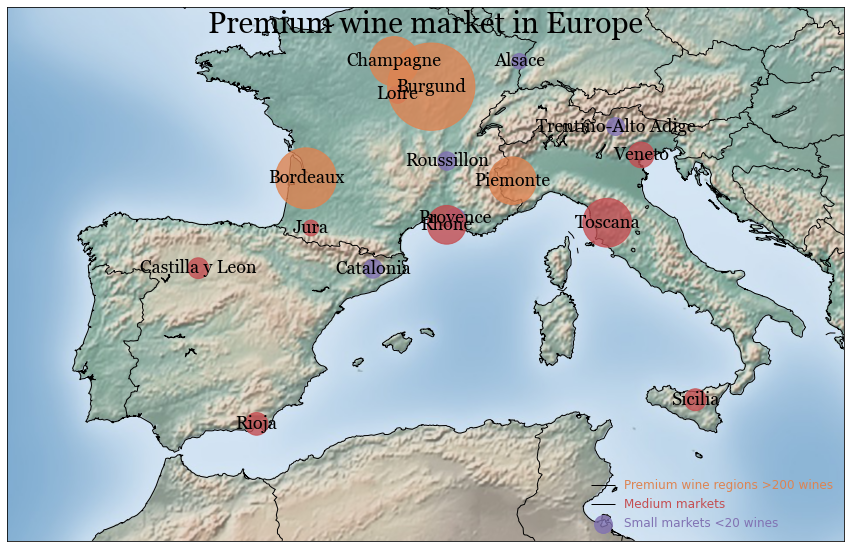

In [115]:
#REGIONS WITH PREMIUM WINES#

#Plotting the regions for geolocated data
regions = df_wine[(df_wine["Country"].isin(["France", "Spain", "Italy"])) 
                  & (df_wine["Region"] != "not found") 
                  & (df_wine["Region"] != " Øvrige") 
                  & (df_wine["Category"] != "Liquor")]
test_regions = regions.groupby("Region")["Country"].count()
regions = test_regions[test_regions>5]
unique_regions = set(regions.index)
regions = zip(regions.index, regions)


#Creating positional dictionary
premium_wine_cities = {
    "name" : [],
    "lat" : [],
    "lon" : []
}

#Getting lat and long for geolocated data
for city in unique_regions:
    name = city
    city = city.lower().strip()
    
    #Checking first if the region is in either 'city'- or 'city_ascii' column
    if (city.lower() in [city.lower().strip() for city in df.loc[:, "city"]]) or (city in [city.lower().strip() for city in df.loc[:, "city_ascii"]]): 
        
        #If we get a match, we iterate over to get the lat and long values
        for i in range(df.shape[0]):
            #Need to check both columns since we got both cities and regions.
            #Cities/Regions 1
            if name.lower().strip() == df.loc[i, "city"].lower().strip():
                name = name.strip()
                premium_wine_cities["name"].append(name)
                premium_wine_cities["lat"].append(df.loc[i, "lat"])
                premium_wine_cities["lon"].append(df.loc[i, "lng"])
                break
                
            #Cities/Regions 2
            if name.lower().strip() == df.loc[i, "city_ascii"].lower().strip():
                name = name.strip()
                premium_wine_cities["name"].append(name)
                premium_wine_cities["lat"].append(df.loc[i, "lat"])
                premium_wine_cities["lon"].append(df.loc[i, "lng"])
                break

#Storing the lat and long in a dataset
regions_df = pd.DataFrame(premium_wine_cities)


#MAP FOR PREMIUM WINES ONLY IN FRANCE, SPAIN AND ITALY# 

#Creating the undirected graph
G = nx.Graph()

#Creating the nodes, adding them to the graph
nodes = [city for city in regions_df.loc[:, "name"]]
G.add_nodes_from(nodes)

#Creating the figure
FIG = plt.figure(figsize= (15,15))

#Drawing the map
m = Basemap(projection='mill', llcrnrlon = -12, llcrnrlat = 33 ,urcrnrlon = 20 ,urcrnrlat = 50,
            resolution='i')

#Adjusting the Basemap
m.drawcountries(linewidth = 1)
m.drawcoastlines(linewidth = 1)
m.shadedrelief()

#Creating a positional of lat and long values
origin, dest = m(regions_df['lon'].values, regions_df['lat'].values)
pos = {}
for count, elem in enumerate(regions_df['name']):
    pos[elem] = (origin[count], dest[count])

#Creating dictionary with weights to how many wines coming from the region
d = {key.strip():count for key, count in regions}

#Drawing the nodes in the network (different colors for different nodes)

#Drawing names of cities with <20 premium wines
nx.draw_networkx_nodes(
        G, 
        pos = pos,
        alpha = 0.8,
        nodelist = [v for v in G.nodes if d[v] <= 20],
        node_size = [d[v]*20 for v in G.nodes if d[v] <= 20],
        node_color = "#8172b3")

#Drawing names of cities with 21 to 100 premium wines 
nx.draw_networkx_nodes(
        G, 
        pos = pos,
        alpha = 0.8,
        nodelist = [v for v in G.nodes if (d[v] > 20) and (d[v] <= 200)],
        node_size = [d[v]*12 for v in G.nodes if (d[v] > 20) and (d[v] <= 200)],
        node_color = "#c44e52")

#Drawing names of cities with >100 premium wines
nx.draw_networkx_nodes(
        G, 
        pos = pos,
        alpha = 0.8,
        nodelist = [v for v in G.nodes if d[v] >200],
        node_size = [d[v]*6 for v in G.nodes if d[v]>200],
        node_color = "#dd8452")


#Adding legend
plt.legend(['Premium wine regions >200 wines', 'Medium markets','Small markets <20 wines'], loc = 4, framealpha = 0,
            prop={'size': 12}, labelcolor = ['#dd8452',"#c44e52", '#8172b3'], facecolor = '#052a61', markerscale=1)

#Drawing names of cities 
nx.draw_networkx_labels(
        G,
        pos = pos,
        labels = {node:node for node in G.nodes()},
        font_color = "black",
        font_size = 18,
        font_family = "Georgia"
)

#Adding a title
plt.title('Premium wine market in Europe\n', fontsize=30,
          color = "black", pad = -60, fontfamily = "Georgia")

#Saving the figure
plt.savefig('premium_wine_country.jpeg', dpi=600)

#Displaying the visualization
plt.show()